In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.SaltRemover import SaltRemover
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors
from supervised import AutoML
from tqdm.notebook import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
df = pd.read_csv(r"path_to_dataset_containing_smiles_and_ki_values")

In [3]:
df['Mols'] = df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df['Mols'] = df['Mols'].apply(lambda x: SaltRemover().StripMol(x) if x else None)
df['Mols'] = df['Mols'].apply(lambda x: Chem.AddHs(x))

<Axes: xlabel='Standard Value', ylabel='Density'>

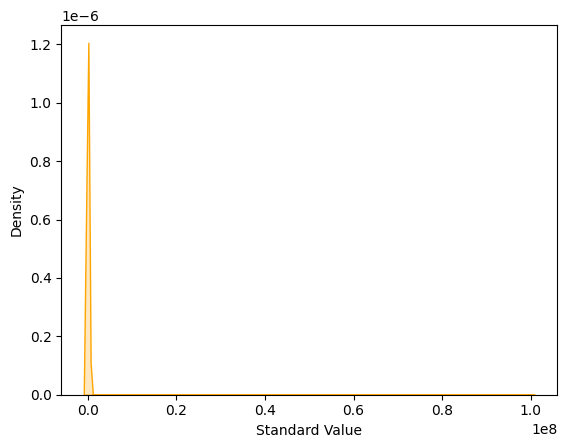

In [5]:
df = df.drop(columns = 'Smiles')
sns.kdeplot(df['Standard Value'], fill=True, color = 'Orange')

<Axes: xlabel='pKi', ylabel='Density'>

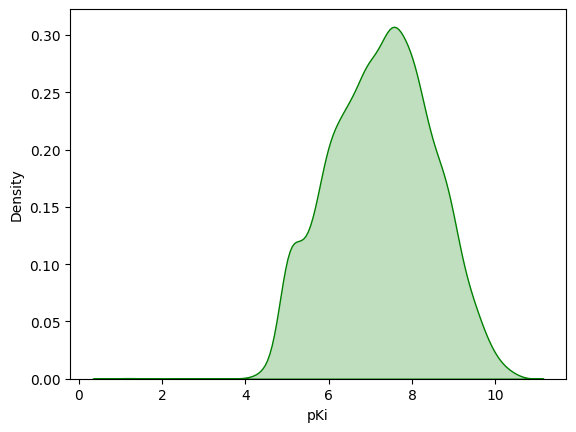

In [6]:
df['Standard Value'] /= 1e9
df['Standard Value'] = df['Standard Value'].apply(lambda x: -np.log10(x))
df = df.rename(columns = {'Standard Value':'pKi'})
sns.kdeplot(df['pKi'], fill=True, color = 'Green')

In [7]:
print(f"Min pKi: {min(df['pKi'])}")
print(f"Max pKi: {max(df['pKi'])}")

Min pKi: 1.0
Max pKi: 10.481486060122112


In [13]:
calc = Calculator(descriptors, ignore_3D=False)
print(f'Amount of decriptors: {len(calc.descriptors)}')

Amount of decriptors: 1826


In [14]:
def generate_3d_coordinates(molecule):
    if molecule is None:
        return None

    status = AllChem.EmbedMolecule(molecule, randomSeed=42)
    if status != 0:
        return None

    AllChem.MMFFOptimizeMolecule(molecule)
    return molecule

In [15]:
d = []

for mol in tqdm(df['Mols'], desc="Calculating descriptors"):
    m = generate_3d_coordinates(mol)
    if m is not None:
        d.append(calc(m))

Calculating descriptors:   0%|          | 0/4690 [00:00<?, ?it/s]

[18:46:49] UFFTYPER: Unrecognized charge state for atom: 5
C:\Users\adamm\anaconda3\envs\nlp0\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
[18:54:23] UFFTYPER: Unrecognized charge state for atom: 8
[19:07:41] UFFTYPER: Unrecognized charge state for atom: 1
[19:09:21] UFFTYPER: Unrecognized charge state for atom: 5
[19:11:03] UFFTYPER: Unrecognized charge state for atom: 1


In [16]:
df_descriptors = pd.DataFrame(d, columns = [name for name in calc.descriptors])
df_descriptors.shape

(4690, 1826)

In [18]:
df_final = pd.concat([df, df_descriptors], axis = 1)
# df_final.to_csv(os.path.join(os.getcwd(), 'df_descriptors_pKi.csv'), index = False)

In [8]:
df_final = df_final.select_dtypes('number')

C:\Users\adamm\AppData\Local\Temp\ipykernel_49108\2469311865.py:1: DtypeWarning: Columns (144,145,153,154,162,163,171,172,180,181,189,190,198,199,207,208,216,217,225,226,234,235,236,237,238,239,240,241,242,243,244,344,345,346,347,348,349,350,351,352,360,361,369,370,378,379,387,388,396,397,405,406,414,415,423,424,432,433,441,442,450,451,452,453,454,455,456,457,458,459,466,467,474,475,482,483,490,491,498,499,506,507,514,515,522,523,530,531,538,539,546,547,548,549,550,551,552,553,554,555,562,563,570,571,578,579,586,587,594,595,602,603,610,611,618,619,626,627,634,635,642,643,644,645,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,877,885,1104,1109,1183,1188,1578,1798) have mixed types. Specify dtype option on import or set low_memory=False.


(4690, 1305)

In [9]:
X = df_final[df_final.columns[2:]]
y = df_final['pKi']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [11]:
automl = AutoML(
    results_path=r"C:\Users\adamm\Desktop\BigStreamlitApp\5ht6_fixed_pKi",
    algorithms=['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network'],
    train_ensemble=True,
    stack_models=True,
    ml_task='regression',
    golden_features=False,
    features_selection=True,
    random_state=42,
    mode='Optuna',
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 10,
        "shuffle": True,
        "random_seed": 42
    }
    
)

In [12]:
automl.fit(X_train, y_train)

AutoML directory: C:\Users\adamm\Desktop\BigStreamlitApp\5ht6_fixed_pKi
Expected computing time:
Time for tuning with Optuna: len(algorithms) * optuna_time_budget = 21600 seconds
There is no time limit for ML model training after Optuna tuning (total_time_limit parameter is ignored).
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'insert_random_feature', 'features_selection', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 6 models
Optuna optimizes LightGBM with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 12:36:24,591] A new study created in memory with name: no-name-4c1b73f9-de58-4e2c-ad39-b53c5e85f608
[I 2025-12-15 12:38:20,935] Trial 0 finished with value: 0.5144921252186192 and parameters: {'learning_rate': 0.025, 'num_leaves': 321, 'lambda_l1': 2.5348407664333426e-07, 'lambda_l2': 3.3323645788192616e-08, 'feature_fraction': 0.9063233107042159, 'bagging_fraction': 0.7207805142313962, 'bagging_freq': 5, 'min_data_in_leaf': 3, 'extra_trees': True}. Best is trial 0 with value: 0.5144921252186192.
[I 2025-12-15 12:38:31,320] Trial 1 finished with value: 0.5508596962077438 and parameters: {'learning_rate': 0.1, 'num_leaves': 1076, 'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06, 'feature_fraction': 0.7282970324241945, 'bagging_fraction': 0.3976457038513679, 'bagging_freq': 3, 'min_data_in_leaf': 37, 'extra_trees': False}. Best is trial 0 with value: 0.5144921252186192.
[I 2025-12-15 12:39:11,131] Trial 2 finished with value: 0.5229639816882993 and param

1_Optuna_LightGBM rmse 0.663704 trained in 301.57 seconds
Optuna optimizes Xgboost with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 13:41:55,801] A new study created in memory with name: no-name-692eef25-64e1-4c81-8bc4-165a55054c4e
[I 2025-12-15 13:42:32,292] Trial 0 finished with value: 0.5503914374994122 and parameters: {'eta': 0.025, 'max_depth': 3, 'lambda': 2.5348407664333426e-07, 'alpha': 3.3323645788192616e-08, 'colsample_bytree': 0.9063233107042159, 'subsample': 0.7207805142313962, 'min_child_weight': 71}. Best is trial 0 with value: 0.5503914374994122.
[I 2025-12-15 13:43:13,897] Trial 1 finished with value: 0.5305205941096545 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 4.4734294104626844e-07, 'alpha': 5.472429642032198e-06, 'colsample_bytree': 0.6673295073901307, 'subsample': 0.6023615173689312, 'min_child_weight': 30}. Best is trial 1 with value: 0.5305205941096545.
[I 2025-12-15 13:44:55,091] Trial 2 finished with value: 0.5135010216454882 and parameters: {'eta': 0.0125, 'max_depth': 7, 'lambda': 0.1165691561324743, 'alpha': 6.267062696005991e-07, 'colsample_bytree': 0.6599641

2_Optuna_Xgboost rmse 0.668332 trained in 429.01 seconds
Optuna optimizes CatBoost with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 14:49:41,018] A new study created in memory with name: no-name-3aec96d9-298d-4978-8f1d-624f5707ff24
[I 2025-12-15 14:50:30,753] Trial 0 finished with value: 0.5351412027927748 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1.560270802560321, 'random_strength': 1.5599452118020811, 'rsm': 0.15227525095137953, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.5351412027927748.
[I 2025-12-15 14:56:23,695] Trial 1 finished with value: 0.5460601940929335 and parameters: {'learning_rate': 0.1, 'depth': 9, 'l2_leaf_reg': 8.324443163740137, 'random_strength': 2.1233911146593702, 'rsm': 0.26364247048639056, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.5351412027927748.
[I 2025-12-15 14:57:01,341] Trial 2 finished with value: 0.5188123875789651 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6.118567761934322, 'random_strength': 1.3949386151254795, 'rsm': 0.3629301836816964, 'min_data_in_leaf': 37}. Best is trial 2 with value: 0.51

3_Optuna_CatBoost rmse 0.673576 trained in 3503.53 seconds
Optuna optimizes Neural Network with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 16:52:55,365] A new study created in memory with name: no-name-24e80885-426a-4177-94eb-054283042569
[I 2025-12-15 16:53:04,473] Trial 0 finished with value: 0.610043160941322 and parameters: {'dense_1_size': 40, 'dense_2_size': 96, 'learning_rate': 0.005, 'learning_rate_type': 'constant', 'alpha': 0.023585940584142682}. Best is trial 0 with value: 0.610043160941322.
[I 2025-12-15 16:53:12,950] Trial 1 finished with value: 0.6227511129045085 and parameters: {'dense_1_size': 5, 'dense_2_size': 98, 'learning_rate': 0.005, 'learning_rate_type': 'constant', 'alpha': 4.17890272377219e-06}. Best is trial 0 with value: 0.610043160941322.
[I 2025-12-15 16:53:18,556] Trial 2 finished with value: 0.9980372291283615 and parameters: {'dense_1_size': 63, 'dense_2_size': 15, 'learning_rate': 0.1, 'learning_rate_type': 'adaptive', 'alpha': 2.6185068507773707e-08}. Best is trial 0 with value: 0.610043160941322.
[I 2025-12-15 16:53:50,851] Trial 3 finished with value: 0.655057131778406 and

4_Optuna_NeuralNetwork rmse 0.768385 trained in 113.03 seconds
Optuna optimizes Random Forest with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 17:55:13,323] A new study created in memory with name: no-name-61f395f8-0c94-4294-bcbc-b5c8e149a878
[I 2025-12-15 17:57:43,872] Trial 0 finished with value: 0.6908458408655032 and parameters: {'max_depth': 13, 'min_samples_split': 96, 'min_samples_leaf': 74, 'max_features': 0.6026718993550663}. Best is trial 0 with value: 0.6908458408655032.
[I 2025-12-15 18:02:15,243] Trial 1 finished with value: 0.6438132556658078 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.8675143843171859}. Best is trial 1 with value: 0.6438132556658078.
[I 2025-12-15 18:09:34,060] Trial 2 finished with value: 0.6093661722142442 and parameters: {'max_depth': 20, 'min_samples_split': 72, 'min_samples_leaf': 3, 'max_features': 0.9702107536403743}. Best is trial 2 with value: 0.6093661722142442.
[I 2025-12-15 18:10:53,027] Trial 3 finished with value: 0.6137568066571735 and parameters: {'max_depth': 27, 'min_samples_split': 23, 'min_samples_leaf': 19

5_Optuna_RandomForest rmse 0.736957 trained in 1144.49 seconds
Optuna optimizes Extra Trees with time budget 3600 seconds eval_metric rmse (minimize)


[I 2025-12-15 19:17:04,967] A new study created in memory with name: no-name-3337d7a4-a4bc-4dc1-a701-3ce0fc84ef97
[I 2025-12-15 19:17:25,901] Trial 0 finished with value: 0.6822828502812447 and parameters: {'max_depth': 13, 'min_samples_split': 96, 'min_samples_leaf': 74, 'max_features': 0.6026718993550663}. Best is trial 0 with value: 0.6822828502812447.
[I 2025-12-15 19:17:55,286] Trial 1 finished with value: 0.663786993251192 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.8675143843171859}. Best is trial 1 with value: 0.663786993251192.
[I 2025-12-15 19:18:56,364] Trial 2 finished with value: 0.5796611779406335 and parameters: {'max_depth': 20, 'min_samples_split': 72, 'min_samples_leaf': 3, 'max_features': 0.9702107536403743}. Best is trial 2 with value: 0.5796611779406335.
[I 2025-12-15 19:19:10,807] Trial 3 finished with value: 0.6121483840721669 and parameters: {'max_depth': 27, 'min_samples_split': 23, 'min_samples_leaf': 19, 

6_Optuna_ExtraTrees rmse 0.686844 trained in 794.47 seconds
* Step insert_random_feature will try to check up to 1 model
1_Optuna_LightGBM_RandomFeature rmse 0.662544 trained in 5214.37 seconds
Drop features ['AXp-7d', 'Xch-7d', 'SdO', 'Xch-5dv', 'MATS4i', 'MATS3p', 'ATSC8s', 'EState_VSA8', 'GGI4', 'VSA_EState5', 'AATSC3v', 'AATS5i', 'MATS5Z', 'NddssS', 'AATS3d', 'PEOE_VSA6', 'EState_VSA9', 'AATSC4m', 'AXp-0d', 'AATSC5i', 'GATS3p', 'ATSC1d', 'GATS6v', 'ATS8pe', 'SpMAD_D', 'AATSC5dv', 'AATSC3dv', 'GATS6m', 'ATS6v', 'AATSC2dv', 'AATSC5are', 'AXp-1d', 'AXp-6dv', 'ATSC5dv', 'AATSC4se', 'ATS8s', 'GATS2pe', 'GATS4i', 'SpMAD_Dzp', 'CIC5', 'SIC3', 'SlogP_VSA10', 'ETA_dEpsilon_C', 'Radius', 'AATSC3d', 'MID_C', 'ATS7pe', 'AATS6s', 'BIC5', 'nG12FRing', 'ATS4m', 'MATS3d', 'MPC10', 'AATS2i', 'GATS6s', 'IC2', 'AATSC2m', 'ATS4dv', 'SM1_Dzv', 'AATSC6d', 'ATS1dv', 'ATSC1p', 'ATS7are', 'ATS5se', 'SpMAD_Dzi', 'CIC3', 'GATS5se', 'ATSC3s', 'PEOE_VSA10', 'AATS6se', 'PEOE_VSA3', 'MATS1Z', 'ATSC2are', 'ATSC5s

,results_path,'C:\\Users\\adamm\\Desk...mlitApp\\5ht6_fixed_pKi'
,total_time_limit,3600
,mode,'Optuna'
,ml_task,'regression'
,model_time_limit,None
,algorithms,"['Random Forest', 'Extra Trees', ...]"
,train_ensemble,True
,stack_models,True
,eval_metric,'auto'
,validation_strategy,"{'k_folds': 10, 'random_seed': 42, 'shuffle': True, 'validation_type': 'kfold'}"
,explain_level,'auto'


In [13]:
df_results = automl.get_leaderboard()
df_results = df_results.sort_values('metric_value')
df_results

,name,model_type,metric_type,metric_value,train_time
26,Ensemble_Stacked,Ensemble,rmse,0.643756,3.66
13,Ensemble,Ensemble,rmse,0.648809,1.14
23,6_Optuna_ExtraTrees_Stacked,Extra Trees,rmse,0.651059,496.47
18,5_Optuna_RandomForest_SelectedFeatures_Stacked,Random Forest,rmse,0.651465,437.22
17,6_Optuna_ExtraTrees_SelectedFeatures_Stacked,Extra Trees,rmse,0.651481,193.78
24,5_Optuna_RandomForest_Stacked,Random Forest,rmse,0.652257,932.58
16,3_Optuna_CatBoost_SelectedFeatures_Stacked,CatBoost,rmse,0.653084,129.45
22,3_Optuna_CatBoost_Stacked,CatBoost,rmse,0.653605,318.98
7,1_Optuna_LightGBM_SelectedFeatures,LightGBM,rmse,0.656317,465.12
8,2_Optuna_Xgboost_SelectedFeatures,Xgboost,rmse,0.656667,381.65


In [14]:
y_pred_test = automl.predict(X_test)
y_pred_train = automl.predict(X_train)

In [15]:
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [16]:
print(f'rmse_train: {rmse_train:.4f}')
print(f'rmse_test: {rmse_test:.4f}')
print(f'r2_test: {r2_train:.4f}')
print(f'r2_test: {r2_test:.4f}')

rmse_train: 0.2691
rmse_test: 0.6303
r2_test: 0.9509
r2_test: 0.7240
